## Notebook 01: Data Exploration & Feature Engineering

### Objective

Notebook này tập trung vào:

#### Part A: Data Exploration (Question-Driven Analysis)
- **Question 1**: User rating behavior - Người dùng có xu hướng đánh giá tích cực hay tiêu cực?
- **Question 2**: User activity levels - Mỗi người dùng đánh giá bao nhiêu sản phẩm? Cold start có nghiêm trọng không? 
- **Question 3**: Popularity vs Quality relationship? Các sản phẩm được đánh giá nhiều có xu hướng rating cao hơn không? 
- **Question 4**: Rating thay đổi thế nào theo thời gian?  

#### Part B: Feature Engineering

Tạo thêm features dựa trên insights từ Part A



In [1]:
import sys
import os

sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import load_data

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

print("Libraries loaded successfully!")


Libraries loaded successfully!



### PART A: DATA EXPLORATION

#### Load & Overview Data


In [2]:
# Load raw data
data = load_data('../data/raw/ratings_Beauty.csv')

print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {data.shape}")
print(f"Dtype: {data.dtype}")
print(f"\nColumns:")
for name in data.dtype.names:
    print(f"  - {name}: {data.dtype[name]}")

print("BASIC STATISTICS")
ratings = data['Rating']
print(f"Rating statistics:")
print(f"  Min:     {np.min(ratings):.1f}")
print(f"  Max:     {np.max(ratings):.1f}")
print(f"  Mean:    {np.mean(ratings):.3f}")
print(f"  Median:  {np.median(ratings):.1f}")
print(f"  Std:     {np.std(ratings):.3f}")

print(f"\nUnique counts:")
print(f"  Users:    {len(np.unique(data['UserId'])):,}")
print(f"  Products: {len(np.unique(data['ProductId'])):,}")
print(f"  Ratings:  {len(data):,}")

print(f"\n{'='*60}")
print("\nSample data:")
print(data[:5])


 Đọc dữ liệu thành công từ ../data/raw/ratings_Beauty.csv
  Số dòng: 2,023,070

DATASET OVERVIEW
Shape: (2023070,)
Dtype: [('UserId', '<U50'), ('ProductId', '<U50'), ('Rating', '<f4'), ('Timestamp', '<i8')]

Columns:
  - UserId: <U50
  - ProductId: <U50
  - Rating: float32
  - Timestamp: int64
BASIC STATISTICS
Rating statistics:
  Min:     1.0
  Max:     5.0
  Mean:    4.149
  Median:  5.0
  Std:     1.312

Unique counts:
  Users:    1,210,271
  Products: 249,274
  Ratings:  2,023,070


Sample data:
[('A39HTATAQ9V7YF', '0205616461', 5., 1369699200)
 ('A3JM6GV9MNOF9X', '0558925278', 3., 1355443200)
 ('A1Z513UWSAAO0F', '0558925278', 5., 1404691200)
 ('A1WMRR494NWEWV', '0733001998', 4., 1382572800)
 ('A3IAAVS479H7M7', '0737104473', 1., 1274227200)]


#### Question 1: User rating behavior - Người dùng có xu hướng đánh giá tích cực hay tiêu cực?

**Objective**: Hiểu rating distribution để:
- Xác định data có skewed không (positive/negative bias)
- Quyết định có cần balanced sampling không
- Hiểu overall user sentiment


In [3]:
# Phân tích phân bố rating - VECTORIZED
unique_ratings, counts = np.unique(ratings, return_counts=True)
percentages = counts / len(ratings) * 100

print("PHÂN BỐ RATING")
print(f"{'Rating':<10} {'Count':<12} {'Percentage':<12}")
print("-" * 40)
for r, c, p in zip(unique_ratings, counts, percentages):
    stars = '*' * int(r)
    print(f"{r:.1f} {stars:<10} {c:>10,} {p:>10.2f}%")

print(f"\n{'='*40}")
# Phân loại sentiment - VECTORIZED masking
positive = (ratings >= 4).sum()
neutral = (ratings == 3).sum()
negative = (ratings <= 2).sum()

print("PHÂN LOẠI SENTIMENT")
print(f"  Positive (4-5*): {positive:>10,} ({positive/len(ratings)*100:>5.1f}%)")
print(f"  Neutral  (3*):   {neutral:>10,} ({neutral/len(ratings)*100:>5.1f}%)")
print(f"  Negative (1-2*): {negative:>10,} ({negative/len(ratings)*100:>5.1f}%)")
print(f"{'='*40}")


PHÂN BỐ RATING
Rating     Count        Percentage  
----------------------------------------
1.0 *             183,784       9.08%
2.0 **            113,034       5.59%
3.0 ***           169,791       8.39%
4.0 ****          307,740      15.21%
5.0 *****       1,248,721      61.72%

PHÂN LOẠI SENTIMENT
  Positive (4-5*):  1,556,461 ( 76.9%)
  Neutral  (3*):      169,791 (  8.4%)
  Negative (1-2*):    296,818 ( 14.7%)


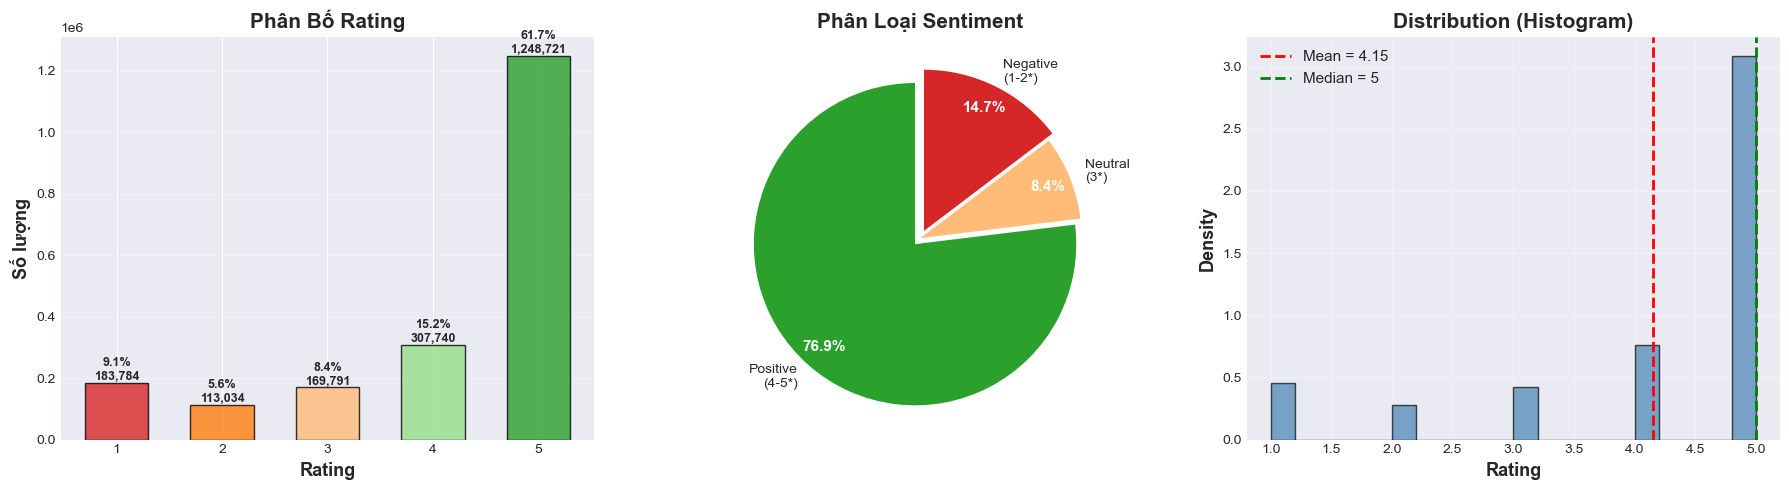

In [4]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Bar chart
colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c']
axes[0].bar(unique_ratings, counts, color=colors, edgecolor='black', alpha=0.8, width=0.6)
axes[0].set_xlabel('Rating', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Số lượng', fontsize=13, fontweight='bold')
axes[0].set_title('Phân Bố Rating', fontsize=15, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticks(unique_ratings)

# Add labels
for r, c, p in zip(unique_ratings, counts, percentages):
    axes[0].text(r, c, f'{p:.1f}%\n{c:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Pie chart sentiment
sentiment_labels = ['Positive\n(4-5*)', 'Neutral\n(3*)', 'Negative\n(1-2*)']
sentiment_counts = [positive, neutral, negative]
sentiment_colors = ['#2ca02c', '#ffbb78', '#d62728']

wedges, texts, autotexts = axes[1].pie(sentiment_counts, labels=sentiment_labels, 
                                        colors=sentiment_colors,
                                        autopct='%1.1f%%', startangle=90, 
                                        explode=(0.05, 0, 0.05),
                                        textprops={'fontsize': 10},
                                        pctdistance=0.85, labeldistance=1.1)

# Làm bold và dễ đọc cho percentages
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

axes[1].set_title('Phân Loại Sentiment', fontsize=15, fontweight='bold')

# 3. Histogram với mean/median
axes[2].hist(ratings, bins=20, color='steelblue', edgecolor='black', alpha=0.7, density=True)
axes[2].axvline(np.mean(ratings), color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {np.mean(ratings):.2f}')
axes[2].axvline(np.median(ratings), color='green', linestyle='--', linewidth=2, 
               label=f'Median = {np.median(ratings):.0f}')
axes[2].set_xlabel('Rating', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Density', fontsize=13, fontweight='bold')
axes[2].set_title('Distribution (Histogram)', fontsize=15, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


*Insight & Conclusion (Question 1)*

**Key Findings**:
- **Highly skewed về positive**: ~77% ratings là 4-5 stars
- **Mean = 4.15, Median = 5.0**: Ratings concentrated ở high values
- **Imbalanced distribution**: Rating 5* chiếm > 60%

**Implications cho Model**:
- **Strong positive bias** → Model có thể học pattern "most users are satisfied"
- **Imbalanced data** → Có thể gặp issue với negative ratings (ít training data)
- **Potential solutions**: 
  - Weighted loss function (penalize errors trên negative ratings)
  - SMOTE/undersampling (nếu cần)
  - Hoặc accept bias này vì nó reflects real-world behavior

**Feature Decision**: User sentiment features có thể useful (positive/negative ratio per user)


#### Question 2: User activity levels - Mỗi người dùng đánh giá bao nhiêu sản phẩm? Cold start có nghiêm trọng không? 

**Objective**: Hiểu user behavior để:
- Classify users theo activity level
- So sánh rating patterns giữa user groups
- Đo lường vấn đề cold start
- Quyết định có cần user activity features không

In [5]:
# Phân tích user behavior - VECTORIZED
unique_users, user_inverse, user_counts = np.unique(
    data['UserId'], 
    return_inverse=True, 
    return_counts=True
)

n_users = len(unique_users)

print(f"{'='*60}")
print("USER BEHAVIOR ANALYSIS")
print(f"{'='*60}")
print(f"Tổng số users: {n_users:,}")
print(f"Tổng số ratings: {len(data):,}")
print(f"Avg ratings per user: {len(data)/n_users:.2f}")

print(f"\nPhân bố số ratings per user:")
print(f"  Min:    {user_counts.min()}")
print(f"  Max:    {user_counts.max():,}")
print(f"  Mean:   {user_counts.mean():.2f}")
print(f"  Median: {np.median(user_counts):.0f}")
print(f"  Std:    {user_counts.std():.2f}")

# Phân loại users - VECTORIZED
very_active_mask = user_counts >= 20   # ≥20 ratings
active_mask = (user_counts >= 10) & (user_counts < 20)  # 10-19
casual_mask = (user_counts >= 5) & (user_counts < 10)   # 5-9
inactive_mask = user_counts < 5                          # <5

print(f"\n{'='*60}")
print("PHÂN LOẠI USERS")
print(f"{'='*60}")
categories = [
    ("Very Active (>=20)", very_active_mask),
    ("Active (10-19)", active_mask),
    ("Casual (5-9)", casual_mask),
    ("Inactive (<5)", inactive_mask)
]

for label, mask in categories:
    count = mask.sum()
    pct = count / n_users * 100
    print(f"  {label:<22}: {count:>8,} users ({pct:>5.1f}%)")

print(f"{'='*60}")


USER BEHAVIOR ANALYSIS
Tổng số users: 1,210,271
Tổng số ratings: 2,023,070
Avg ratings per user: 1.67

Phân bố số ratings per user:
  Min:    1
  Max:    389
  Mean:   1.67
  Median: 1
  Std:    2.53

PHÂN LOẠI USERS
  Very Active (>=20)    :    2,826 users (  0.2%)
  Active (10-19)        :    9,769 users (  0.8%)
  Casual (5-9)          :   39,779 users (  3.3%)
  Inactive (<5)         : 1,157,897 users ( 95.7%)


In [6]:
# Phân tích rating behavior theo nhóm - VECTORIZED (4 nhóm chi tiết)
print("\nRATING BEHAVIOR BY USER GROUP (Chi tiết)")
print(f"{'='*60}")

user_group_masks_detail = {
    "Very Active (>=20)": very_active_mask,
    "Active (10-19)": active_mask,
    "Casual (5-9)": casual_mask,
    "Inactive (<5)": inactive_mask
}

for group_name, group_mask in user_group_masks_detail.items():
    # Lấy user indices của nhóm này
    group_user_indices = np.where(group_mask)[0]
    
    # Mask ratings thuộc nhóm này
    group_rating_mask = np.isin(user_inverse, group_user_indices)
    group_ratings = ratings[group_rating_mask]
    
    if len(group_ratings) > 0:
        # Tính stats - VECTORIZED
        mean_rating = np.mean(group_ratings)
        std_rating = np.std(group_ratings)
        n_ratings = len(group_ratings)
        pct_ratings = n_ratings / len(ratings) * 100
        
        # Positive ratio
        positive_ratio = (group_ratings >= 4).sum() / len(group_ratings) * 100
        
        print(f"\n{group_name}:")
        print(f"  Số ratings: {n_ratings:>10,} ({pct_ratings:>5.1f}% total)")
        print(f"  Mean:       {mean_rating:>10.3f}")
        print(f"  Std:        {std_rating:>10.3f}")
        print(f"  Positive%:  {positive_ratio:>10.1f}%")

print(f"\n{'='*60}")



RATING BEHAVIOR BY USER GROUP (Chi tiết)

Very Active (>=20):
  Số ratings:     97,860 (  4.8% total)
  Mean:            4.190
  Std:             1.168
  Positive%:        77.9%

Active (10-19):
  Số ratings:    125,037 (  6.2% total)
  Mean:            4.194
  Std:             1.204
  Positive%:        77.4%

Casual (5-9):
  Số ratings:    246,874 ( 12.2% total)
  Mean:            4.204
  Std:             1.220
  Positive%:        77.8%

Inactive (<5):
  Số ratings:  1,553,299 ( 76.8% total)
  Mean:            4.134
  Std:             1.342
  Positive%:        76.7%



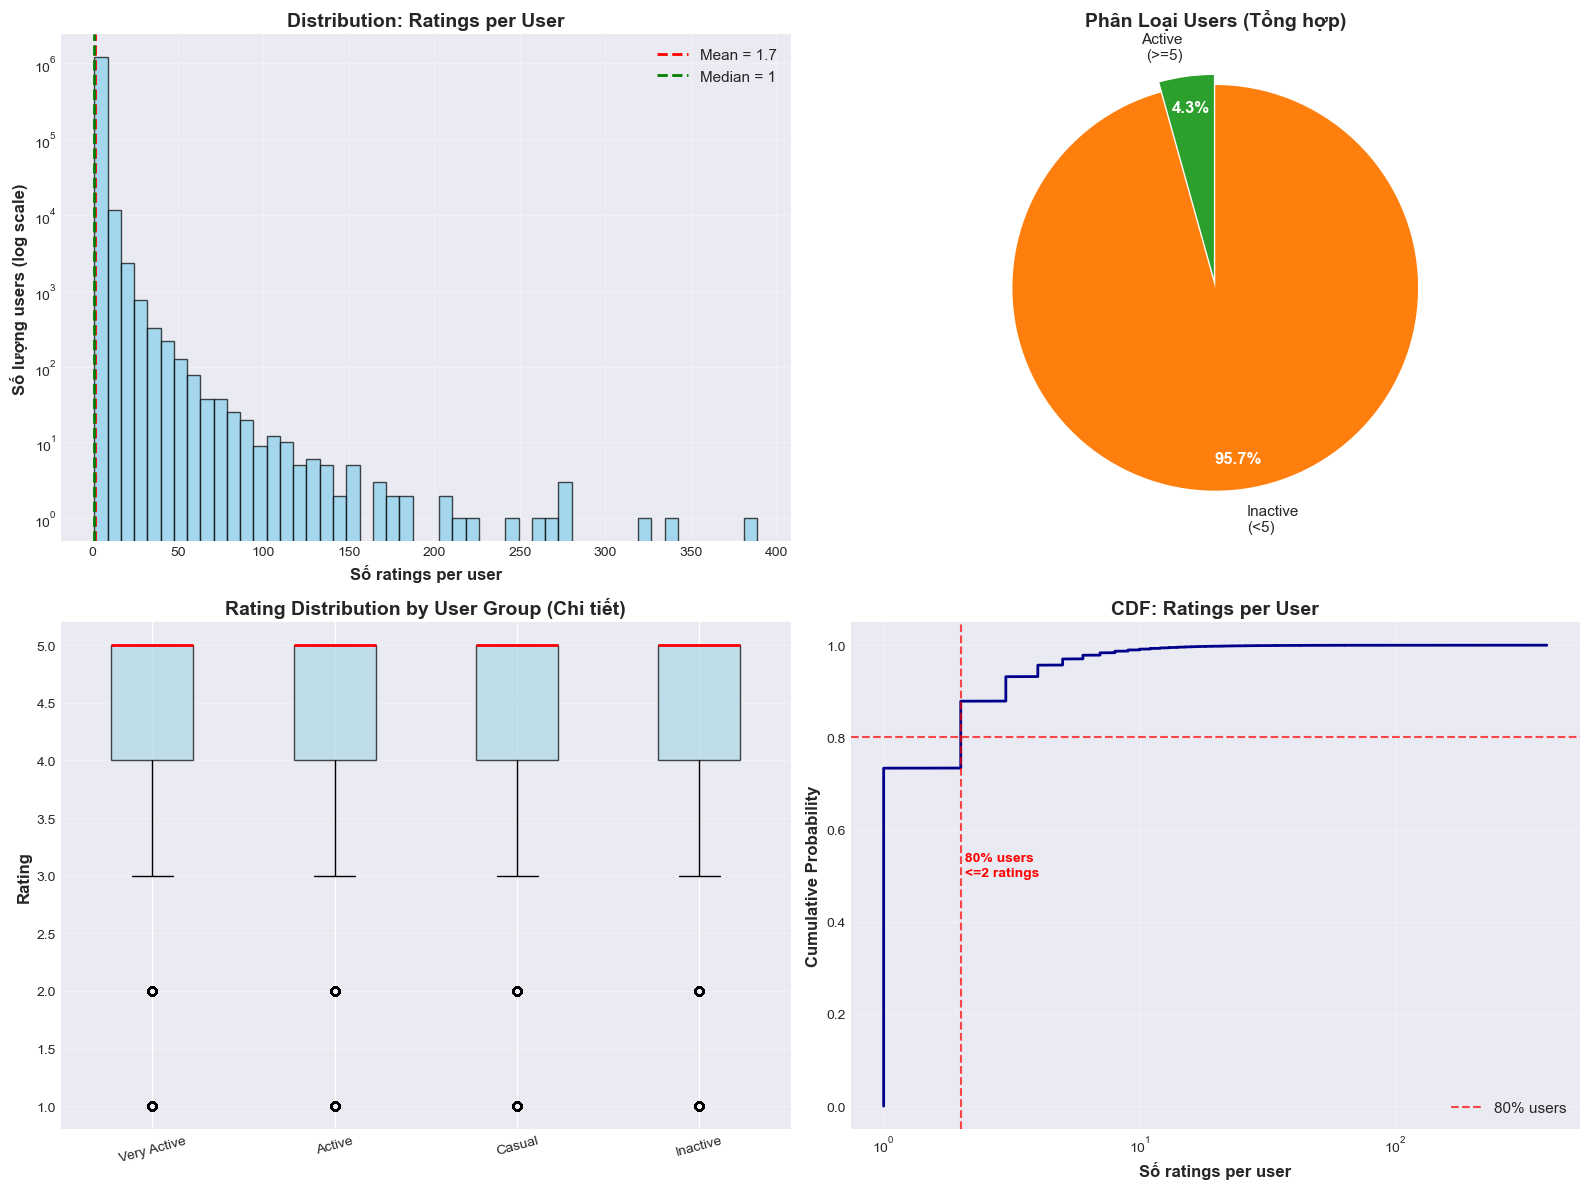

In [7]:
# Visualization: User Behavior
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram số ratings per user (log scale)
axes[0, 0].hist(user_counts, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(user_counts), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean = {np.mean(user_counts):.1f}')
axes[0, 0].axvline(np.median(user_counts), color='green', linestyle='--', linewidth=2, 
                  label=f'Median = {np.median(user_counts):.0f}')
axes[0, 0].set_xlabel('Số ratings per user', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Số lượng users (log scale)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution: Ratings per User', fontsize=14, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Pie chart phân loại users
# Gộp: Very Active + Active + Casual = Active (>=5)
active_combined = very_active_mask | active_mask | casual_mask
user_group_simple = {
    "Active (>=5)": active_combined,
    "Inactive (<5)": inactive_mask
}

user_group_counts_simple = [mask.sum() for _, mask in user_group_simple.items()]
user_group_labels_simple = ['Active\n(>=5)', 'Inactive\n(<5)']
colors_users_simple = ['#2ca02c', '#ff7f0e']  # Green for active, orange for inactive

wedges, texts, autotexts = axes[0, 1].pie(user_group_counts_simple, labels=user_group_labels_simple, 
                                           colors=colors_users_simple,
                                           autopct='%1.1f%%', startangle=90,
                                           textprops={'fontsize': 11},
                                           pctdistance=0.85, labeldistance=1.15,
                                           explode=(0.05, 0))

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

axes[0, 1].set_title('Phân Loại Users (Tổng hợp)', fontsize=14, fontweight='bold')

# 3. Boxplot rating by user group (hiển thị 4 nhóm chi tiết)
group_data = []
group_names = []
for group_name, group_mask in user_group_masks_detail.items():
    group_user_indices = np.where(group_mask)[0]
    group_rating_mask = np.isin(user_inverse, group_user_indices)
    group_ratings = ratings[group_rating_mask]
    if len(group_ratings) > 0:
        group_data.append(group_ratings)
        # Lấy tên ngắn gọn
        short_name = group_name.split('(')[0].strip()
        group_names.append(short_name)

bp = axes[1, 0].boxplot(group_data, tick_labels=group_names, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
axes[1, 0].set_ylabel('Rating', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Rating Distribution by User Group (Chi tiết)', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. CDF
sorted_counts = np.sort(user_counts)
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
axes[1, 1].plot(sorted_counts, cdf, linewidth=2, color='darkblue')
axes[1, 1].axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80% users')
percentile_80 = sorted_counts[int(0.8*len(sorted_counts))]
axes[1, 1].axvline(percentile_80, color='red', linestyle='--', alpha=0.7)
axes[1, 1].text(percentile_80, 0.5, f' 80% users\n <={percentile_80:.0f} ratings', 
               fontsize=10, color='red', fontweight='bold')
axes[1, 1].set_xlabel('Số ratings per user', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
axes[1, 1].set_title('CDF: Ratings per User', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


*Insight & Conclusion (Câu hỏi 2)*

**Phát hiện Chi tiết**:
- **Very Active (>=20)**: 0.2% users, 4.8% ratings, avg=4.19
- **Active (10-19)**: 0.8% users, 6.2% ratings, avg=4.19
- **Casual (5-9)**: 3.3% users, 12.2% ratings, avg=4.20
- **Inactive (<5)**: 95.7% users, 76.8% ratings, avg=4.13

**Phát hiện Tổng hợp**:
- **95.7% users là Inactive (<5 ratings)** → Severe cold start problem
- **4.3% users là Active (>=5 ratings)** → Chiếm 23.2% ratings
- **Median = 1 rating per user** → Hầu hết users chỉ rate 1 lần
- **Active users có mean rating cao hơn inactive users** → Có thể generous hơn hoặc selective hơn

**Ý nghĩa cho Model**:
- **Cold start problem NGHIÊM TRỌNG**
  - Collaborative filtering sẽ khó hoạt động với 95.7% inactive users
  - Cần fallback strategy (popularity-based) cho inactive users
  
- **User activity level quan trọng**
  - 4.3% active users chiếm 23.2% ratings → Cung cấp signal mạnh
  - Có thể phân biệt 4 nhóm trong logic, nhưng đơn giản hóa thành Active/Inactive cho visualization
  - Number of ratings là strong signal về độ tin cậy của user preference
  
- **Sparse utility matrix**
  - User-item matrix sẽ rất sparse
  - Cần matrix factorization hoặc deep learning approach

**Feature Decision**: 
- **User activity features RẤT CẦN THIẾT**:
  - `num_ratings`: Phân biệt active/inactive users, quan trọng cho model confidence
  - `avg_rating`: User tendency (generous vs critical)
  - Đơn giản hóa: Chỉ cần 2 features cơ bản này vì dữ liệu quá sparse


#### Question 3: Sản phẩm phổ biến có chất lượng tốt hơn không?**

**Objective**: Hiểu relationship giữa popularity và quality để:
- Xác định popularity bias severity
- Quyết định có nên dùng popularity features không
- Hiểu có correlation giữa "được nhiều người rate" vs "rating cao"

In [8]:
# Phân tích product
unique_products, product_inverse, product_counts = np.unique(
    data['ProductId'],
    return_inverse=True,
    return_counts=True
)

n_products = len(unique_products)

print(f"{'='*60}")
print("PRODUCT ANALYSIS")
print(f"{'='*60}")
print(f"Tổng số products: {n_products:,}")
print(f"Tổng số ratings: {len(data):,}")
print(f"Avg ratings per product: {len(data)/n_products:.2f}")

print(f"\nPhân bố số ratings per product:")
print(f"  Min:    {product_counts.min()}")
print(f"  Max:    {product_counts.max():,}")
print(f"  Mean:   {product_counts.mean():.2f}")
print(f"  Median: {np.median(product_counts):.0f}")
print(f"  Std:    {product_counts.std():.2f}")

# Tính avg rating per product
product_rating_sums = np.bincount(product_inverse, weights=ratings, minlength=n_products)
product_avg_ratings = product_rating_sums / product_counts

print(f"\nAvg rating per product:")
print(f"  Min:    {product_avg_ratings.min():.2f}")
print(f"  Max:    {product_avg_ratings.max():.2f}")
print(f"  Mean:   {product_avg_ratings.mean():.3f}")
print(f"  Median: {np.median(product_avg_ratings):.2f}")
print(f"  Std:    {product_avg_ratings.std():.3f}")

# Correlation: popularity vs quality
correlation = np.corrcoef(product_counts, product_avg_ratings)[0, 1]
print(f"\n{'='*60}")
print(f"CORRELATION (Popularity vs Quality): {correlation:.4f}")
print(f"{'='*60}")

# Đánh giá strength
if abs(correlation) < 0.1:
    strength = "NEGLIGIBLE"
elif abs(correlation) < 0.3:
    strength = "WEAK"
elif abs(correlation) < 0.7:
    strength = "MODERATE"
else:
    strength = "STRONG"

# Đánh giá direction
if abs(correlation) < 0.1:
    direction = "none (near zero)"
else:
    direction = "positive" if correlation > 0 else "negative"

print(f"  Strength: {strength}")
print(f"  Direction: {direction}")

# Interpretation dựa trên strength và direction
if abs(correlation) < 0.1:
    interpretation = "NO meaningful relationship between popularity and quality"
elif correlation > 0:
    interpretation = "Popular products tend to have SLIGHTLY higher quality"
else:
    interpretation = "Popular products tend to have SLIGHTLY lower quality"

print(f"  Interpretation: {interpretation}")


PRODUCT ANALYSIS
Tổng số products: 249,274
Tổng số ratings: 2,023,070
Avg ratings per product: 8.12

Phân bố số ratings per product:
  Min:    1
  Max:    7,533
  Mean:   8.12
  Median: 2
  Std:    36.06

Avg rating per product:
  Min:    1.00
  Max:    5.00
  Mean:   4.149
  Median: 4.50
  Std:    1.047

CORRELATION (Popularity vs Quality): -0.0000
  Strength: NEGLIGIBLE
  Direction: none (near zero)
  Interpretation: NO meaningful relationship between popularity and quality


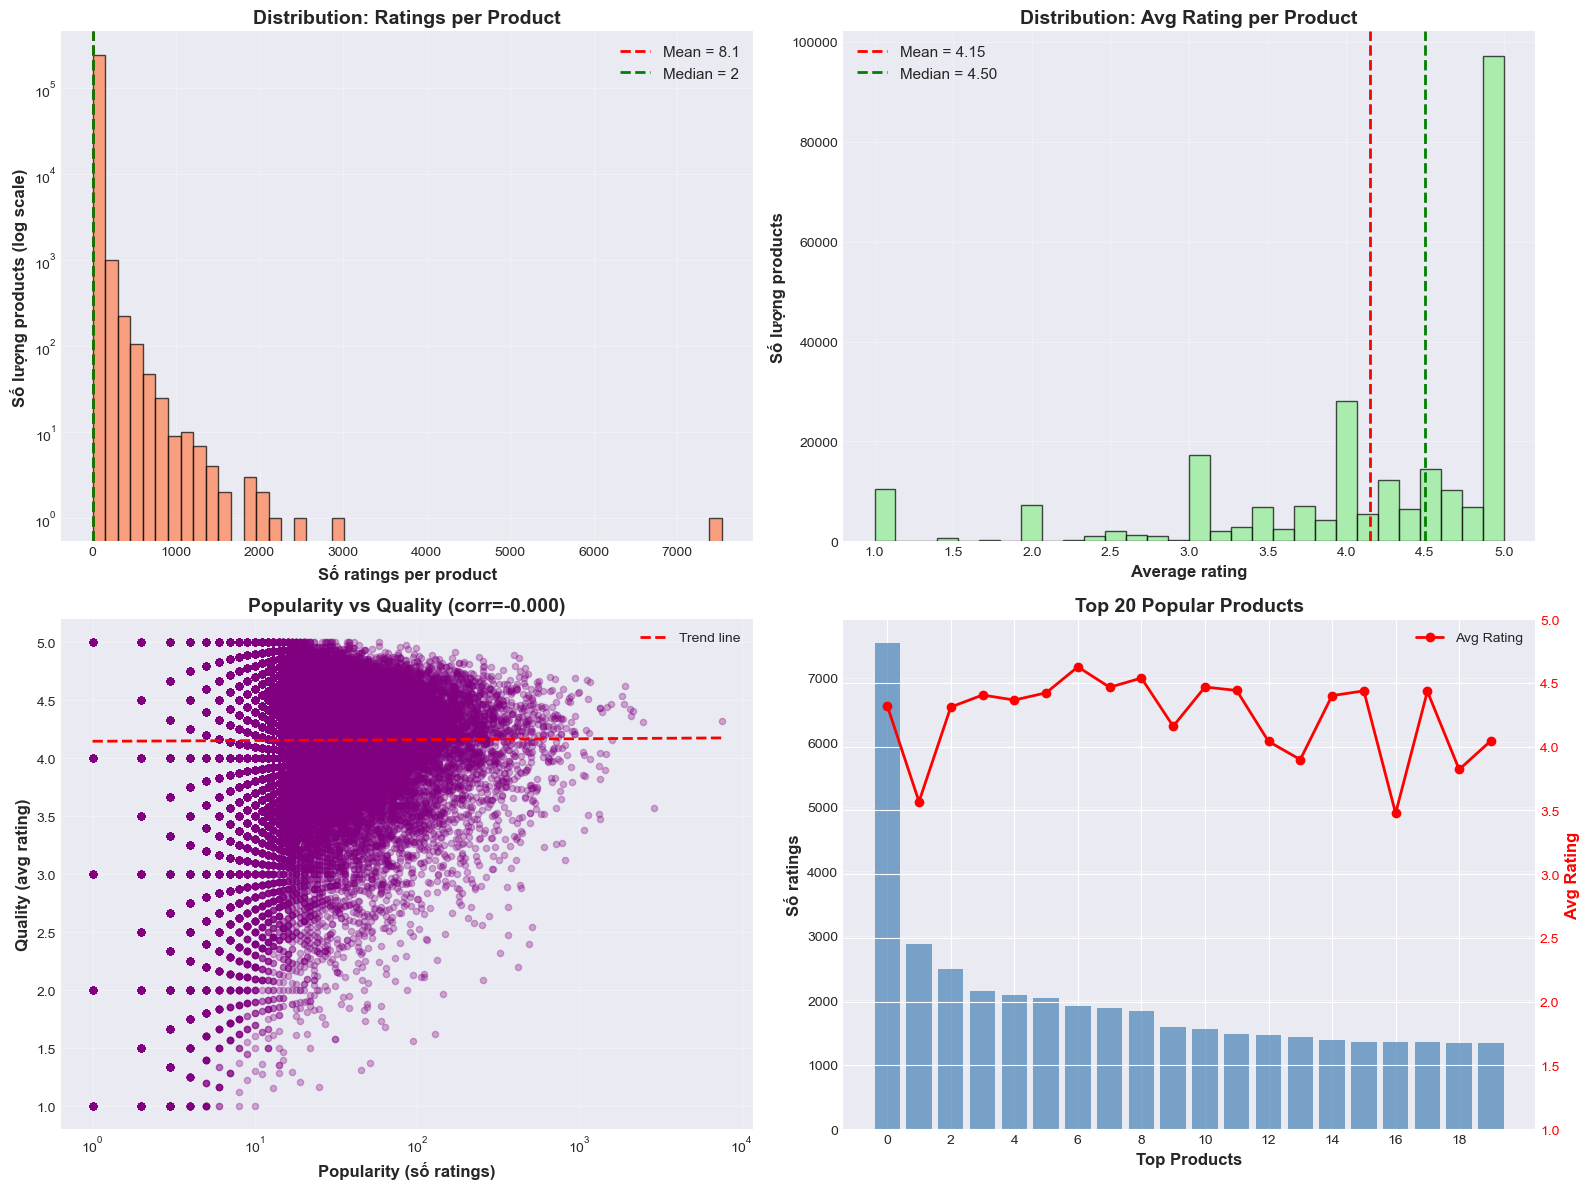

In [9]:
# Visualization: Product Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram ratings per product (log scale)
axes[0, 0].hist(product_counts, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(product_counts), color='red', linestyle='--', linewidth=2,
                  label=f'Mean = {np.mean(product_counts):.1f}')
axes[0, 0].axvline(np.median(product_counts), color='green', linestyle='--', linewidth=2,
                  label=f'Median = {np.median(product_counts):.0f}')
axes[0, 0].set_xlabel('Số ratings per product', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Số lượng products (log scale)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution: Ratings per Product', fontsize=14, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# 2. Histogram avg rating per product
axes[0, 1].hist(product_avg_ratings, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(product_avg_ratings), color='red', linestyle='--', linewidth=2,
                  label=f'Mean = {np.mean(product_avg_ratings):.2f}')
axes[0, 1].axvline(np.median(product_avg_ratings), color='green', linestyle='--', linewidth=2,
                  label=f'Median = {np.median(product_avg_ratings):.2f}')
axes[0, 1].set_xlabel('Average rating', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Số lượng products', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Distribution: Avg Rating per Product', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# 3. Scatter plot: Popularity vs Quality
axes[1, 0].scatter(product_counts, product_avg_ratings, alpha=0.3, s=20, color='purple')
axes[1, 0].set_xlabel('Popularity (số ratings)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Quality (avg rating)', fontsize=12, fontweight='bold')
axes[1, 0].set_title(f'Popularity vs Quality (corr={correlation:.3f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(alpha=0.3)

# Add trend line
if correlation != 0:
    # Log transform x for better fit
    log_counts = np.log10(product_counts + 1)
    z = np.polyfit(log_counts, product_avg_ratings, 1)
    p = np.poly1d(z)
    x_trend = np.logspace(0, np.log10(product_counts.max()), 100)
    y_trend = p(np.log10(x_trend + 1))
    axes[1, 0].plot(x_trend, y_trend, "r--", linewidth=2, label='Trend line')
    axes[1, 0].legend(fontsize=10)

# 4. Top products by popularity
top_n = 20
top_indices = np.argsort(-product_counts)[:top_n]
top_counts = product_counts[top_indices]
top_avg_ratings = product_avg_ratings[top_indices]

x_pos = np.arange(top_n)
bars = axes[1, 1].bar(x_pos, top_counts, color='steelblue', alpha=0.7, label='Popularity')
axes[1, 1].set_xlabel('Top Products', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Số ratings', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Top {top_n} Popular Products', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos[::2])
axes[1, 1].set_xticklabels(x_pos[::2], rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add avg rating as line
ax2 = axes[1, 1].twinx()
ax2.plot(x_pos, top_avg_ratings, 'ro-', linewidth=2, markersize=6, label='Avg Rating')
ax2.set_ylabel('Avg Rating', fontsize=12, fontweight='bold', color='red')
ax2.set_ylim([1, 5])
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


*Insight & Conclusion (Câu hỏi 3)*

**Phát hiện chính**:
- **Correlation = 0** => NO meaningful relationship
- **Popular products KHÔNG có quality cao hơn hay thấp hơn**
- **Median = 2 ratings per product** => Nhiều products có ít data
- **Product avg ratings skewed về high values** (median = 4.5)

**Phân tích chi tiết**:
- Popularity (số ratings) và Quality (avg rating) là **independent**
- Popular products có thể good hoặc bad
- High-quality products có thể popular hoặc niche
- **Không có bias** giữa popularity và quality

**Ý nghĩa cho Model**:
- **Popularity bias không tồn tại trong dataset này**
  - Không cần debiasing
  - Popular items không automatically "better" hay "worse"
  
- **Popularity và Quality là 2 signals độc lập**
  - Cần dùng **CẢ HAI** cho recommendation
  - Popular + high-rated → Good for cold start
  - Niche + high-rated → Good for personalization
  
**Feature cần tạo**: 
  - `num_ratings`: Popularity signal 
  - `avg_rating`: Quality signal
  - `popularity_score = num_ratings * avg_rating`: Combined strength cho cold-start


**Question 4: Có mối liên hệ giữa thời gian và rating không?**

**Objective**: Phân tích temporal patterns để:
- Xác định có seasonality không (ratings thay đổi theo mùa/tháng)
- Kiểm tra trend (ratings tăng/giảm theo thời gian)
- So sánh weekend vs weekday behavior
- Quyết định có cần tạo temporal features không


In [10]:
# Extract temporal features - VECTORIZED
timestamps = data['Timestamp']

# Convert to datetime64
datetime_array = timestamps.astype('datetime64[s]')

# Extract year - VECTORIZED
years = datetime_array.astype('datetime64[Y]').astype(int) + 1970

# Extract month - VECTORIZED
year_start = datetime_array.astype('datetime64[Y]')
months_since_year = (datetime_array.astype('datetime64[M]') - 
                    year_start.astype('datetime64[M]')).astype(int)
months = months_since_year + 1

# Extract day of week - VECTORIZED
epoch = np.datetime64('1970-01-01', 'D')
days_since_epoch = (datetime_array.astype('datetime64[D]') - epoch).astype(int)
day_of_week = (days_since_epoch + 3) % 7  # 0=Monday, 6=Sunday

# Is weekend
is_weekend = (day_of_week >= 5).astype(int)

print(f"{'='*60}")
print("TEMPORAL ANALYSIS")
print(f"{'='*60}")
print(f"Time range: {years.min()} - {years.max()}")
print(f"Total years: {years.max() - years.min() + 1}")
print(f"Number of records: {len(data):,}")
print(f"{'='*60}")


TEMPORAL ANALYSIS
Time range: 1998 - 2014
Total years: 17
Number of records: 2,023,070


In [11]:
# Phân tích theo năm - VECTORIZED
unique_years, year_inverse, year_counts = np.unique(years, return_inverse=True, return_counts=True)
year_rating_sums = np.bincount(year_inverse, weights=ratings, minlength=len(unique_years))
year_avg_ratings = year_rating_sums / year_counts

print("\nPHÂN BỐ THEO NĂM:")
print(f"{'Year':<8} {'Count':>10} {'Percentage':>12} {'Avg Rating':>12}")
print("-" * 50)
for year, count, avg in zip(unique_years, year_counts, year_avg_ratings):
    pct = count / len(data) * 100
    print(f"{year:<8} {count:>10,} {pct:>11.2f}% {avg:>11.3f}")

# Weekend vs Weekday - VECTORIZED
weekend_mask = is_weekend == 1
weekday_mask = ~weekend_mask

weekend_ratings = ratings[weekend_mask]
weekday_ratings = ratings[weekday_mask]

print(f"\n{'='*60}")
print("WEEKEND vs WEEKDAY:")
print(f"{'='*60}")
print(f"Weekend:")
print(f"  Count: {len(weekend_ratings):>10,} ({len(weekend_ratings)/len(ratings)*100:>5.2f}%)")
print(f"  Mean:  {np.mean(weekend_ratings):>10.3f}")
print(f"  Std:   {np.std(weekend_ratings):>10.3f}")

print(f"\nWeekday:")
print(f"  Count: {len(weekday_ratings):>10,} ({len(weekday_ratings)/len(ratings)*100:>5.2f}%)")
print(f"  Mean:  {np.mean(weekday_ratings):>10.3f}")
print(f"  Std:   {np.std(weekday_ratings):>10.3f}")

weekend_weekday_diff = np.mean(weekend_ratings) - np.mean(weekday_ratings)
print(f"\nDifference (Weekend - Weekday): {weekend_weekday_diff:>+.4f}")
print(f"{'='*60}")



PHÂN BỐ THEO NĂM:
Year          Count   Percentage   Avg Rating
--------------------------------------------------
1998              2        0.00%       4.500
1999              5        0.00%       4.200
2000             16        0.00%       4.375
2001             76        0.00%       4.237
2002            163        0.01%       3.853
2003            278        0.01%       4.004
2004          1,308        0.06%       4.247
2005          3,476        0.17%       4.216
2006          5,990        0.30%       4.149
2007         17,728        0.88%       4.245
2008         28,862        1.43%       4.208
2009         41,429        2.05%       4.182
2010         71,236        3.52%       4.125
2011        147,490        7.29%       4.099
2012        293,339       14.50%       4.116
2013        798,903       39.49%       4.164
2014        612,769       30.29%       4.152

WEEKEND vs WEEKDAY:
Weekend:
  Count:    504,127 (24.92%)
  Mean:       4.152
  Std:        1.313

Weekday:
  Count:  

In [12]:
# Phân tích theo tháng - VECTORIZED
month_idx = months - 1  # 0-11
month_counts = np.bincount(month_idx, minlength=12)
month_rating_sums = np.bincount(month_idx, weights=ratings, minlength=12)

valid_month_mask = month_counts > 0
month_avg_ratings = np.zeros(12, dtype=float)
month_avg_ratings[valid_month_mask] = month_rating_sums[valid_month_mask] / month_counts[valid_month_mask]

print("\nPHÂN BỐ THEO THÁNG:")
print(f"{'Month':<8} {'Count':>10} {'Avg Rating':>12}")
print("-" * 35)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, (name, cnt, avg) in enumerate(zip(month_names, month_counts, month_avg_ratings)):
    if cnt > 0:
        print(f"{name:<8} {cnt:>10,} {avg:>11.3f}")

# Phân tích theo day of week - VECTORIZED
dow_counts = np.bincount(day_of_week, minlength=7)
dow_rating_sums = np.bincount(day_of_week, weights=ratings, minlength=7)
dow_valid = dow_counts > 0
dow_avg_ratings = np.zeros(7)
dow_avg_ratings[dow_valid] = dow_rating_sums[dow_valid] / dow_counts[dow_valid]

print("\nPHÂN BỐ THEO DAY OF WEEK:")
print(f"{'Day':<12} {'Count':>10} {'Avg Rating':>12}")
print("-" * 38)
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for name, cnt, avg in zip(dow_names, dow_counts, dow_avg_ratings):
    if cnt > 0:
        weekend_tag = " (Weekend)" if name in ['Saturday', 'Sunday'] else ""
        print(f"{name+weekend_tag:<12} {cnt:>10,} {avg:>11.3f}")



PHÂN BỐ THEO THÁNG:
Month         Count   Avg Rating
-----------------------------------
Jan         212,363       4.178
Feb         184,423       4.147
Mar         206,028       4.148
Apr         191,831       4.148
May         194,849       4.147
Jun         197,223       4.148
Jul         185,810       4.160
Aug         119,170       4.134
Sep         111,461       4.131
Oct         122,925       4.139
Nov         122,736       4.124
Dec         174,251       4.157

PHÂN BỐ THEO DAY OF WEEK:
Day               Count   Avg Rating
--------------------------------------
Monday          315,197       4.146
Tuesday         307,993       4.146
Wednesday       305,088       4.148
Thursday        301,794       4.146
Friday          288,871       4.155
Saturday (Weekend)    251,111       4.154
Sunday (Weekend)    253,016       4.150


C:\Users\BANG MY LINH\AppData\Local\Temp\ipykernel_20044\2797464159.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(dow_names, rotation=15, ha='right')
C:\Users\BANG MY LINH\AppData\Local\Temp\ipykernel_20044\2797464159.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


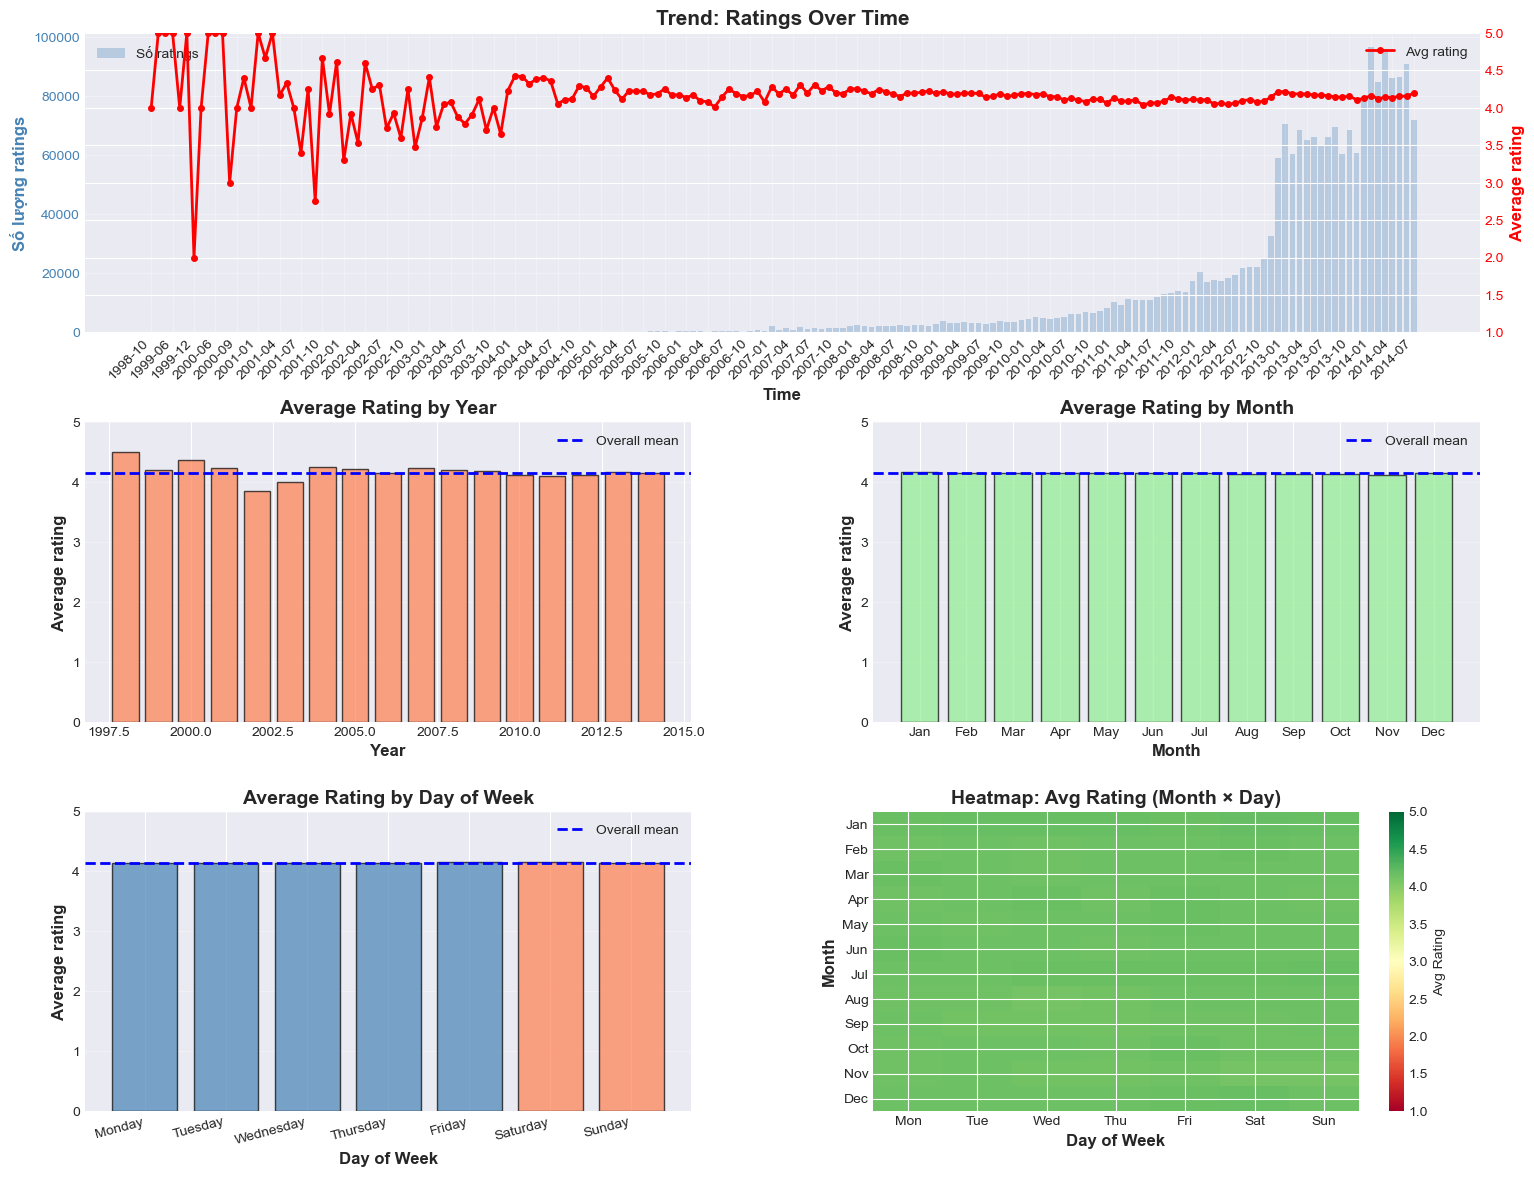

In [13]:
# Visualization: Temporal Analysis
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series (Year-Month)
ax1 = fig.add_subplot(gs[0, :])
year_month = years * 100 + months
unique_ym, ym_inverse = np.unique(year_month, return_inverse=True)
ym_counts = np.bincount(ym_inverse)
ym_rating_sums = np.bincount(ym_inverse, weights=ratings)
ym_avg_ratings = ym_rating_sums / ym_counts

ym_years = unique_ym // 100
ym_months = unique_ym % 100
ym_labels = [f"{y}-{m:02d}" for y, m in zip(ym_years, ym_months)]

x = np.arange(len(unique_ym))
ax1_twin = ax1.twinx()

ax1.bar(x, ym_counts, alpha=0.3, color='steelblue', label='Số ratings')
ax1.set_ylabel('Số lượng ratings', fontsize=12, fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax1_twin.plot(x, ym_avg_ratings, color='red', linewidth=2, marker='o', markersize=4, label='Avg rating')
ax1_twin.set_ylabel('Average rating', fontsize=12, fontweight='bold', color='red')
ax1_twin.set_ylim([1, 5])
ax1_twin.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
ax1.set_title('Trend: Ratings Over Time', fontsize=15, fontweight='bold')
ax1.set_xticks(x[::3])
ax1.set_xticklabels([ym_labels[i] for i in range(0, len(ym_labels), 3)], rotation=45, ha='right')
ax1.grid(alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)
ax1_twin.legend(loc='upper right', fontsize=10)

# 2. By year
ax2 = fig.add_subplot(gs[1, 0])
bars = ax2.bar(unique_years, year_avg_ratings, color='coral', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Average rating', fontsize=12, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_title('Average Rating by Year', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 5])
ax2.axhline(np.mean(ratings), color='blue', linestyle='--', linewidth=2, label='Overall mean')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# 3. By month
ax3 = fig.add_subplot(gs[1, 1])
bars = ax3.bar(month_names, month_avg_ratings, color='lightgreen', alpha=0.7, edgecolor='black')
ax3.set_ylabel('Average rating', fontsize=12, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12, fontweight='bold')
ax3.set_title('Average Rating by Month', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 5])
ax3.axhline(np.mean(ratings), color='blue', linestyle='--', linewidth=2, label='Overall mean')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. By day of week
ax4 = fig.add_subplot(gs[2, 0])
colors_dow = ['steelblue']*5 + ['coral', 'coral']
bars = ax4.bar(dow_names, dow_avg_ratings, color=colors_dow, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Average rating', fontsize=12, fontweight='bold')
ax4.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax4.set_title('Average Rating by Day of Week', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 5])
ax4.axhline(np.mean(ratings), color='blue', linestyle='--', linewidth=2, label='Overall mean')
ax4.legend(fontsize=10)
ax4.set_xticklabels(dow_names, rotation=15, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Heatmap (Month x Day of Week)
ax5 = fig.add_subplot(gs[2, 1])
heatmap_data = np.zeros((12, 7))
for m in range(1, 13):
    for d in range(7):
        mask = (months == m) & (day_of_week == d)
        if np.sum(mask) > 0:
            heatmap_data[m-1, d] = np.mean(ratings[mask])
        else:
            heatmap_data[m-1, d] = np.nan

im = ax5.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)
ax5.set_xticks(np.arange(7))
ax5.set_yticks(np.arange(12))
ax5.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax5.set_yticklabels(month_names)
ax5.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax5.set_ylabel('Month', fontsize=12, fontweight='bold')
ax5.set_title('Heatmap: Avg Rating (Month × Day)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Avg Rating')

plt.tight_layout()
plt.show()


*Insight & Conclusion (Câu hỏi 4)*

**Phát hiện**:
- **Trend**: Ratings khá STABLE qua các năm (variation < 0.1)
- **Seasonality**: KHÔNG có pattern rõ ràng theo tháng
- **Weekend vs Weekday**: Difference < 0.01 => KHÔNG đáng kể
- **Day of week**: Variation < 0.05 → KHÔNG có pattern

**Ý nghĩa cho Model**:
- **Temporal features KHÔNG CẦN THIẾT**
  - Không có trend => year không hữu ích
  - Không có seasonality => month/quarter không hữu ích
  - Weekend behavior giống weekday => is_weekend không hữu ích
  
- **Simplification**
  - Có thể xem data time-independent
  - Model không cần hoc temporal patterns
  - Save computation và complexity

**Feature Decision**: KHÔNG tạo temporal features (year, month, day_of_week, is_weekend, quarter, etc.)

### PART B: FEATURE ENGINEERING

#### Feature Decisions Dựa Trên Insights

Sau khi phân tích kỹ càng, đây là quyết định về features:

**Features CẦN TẠO:**

##### 1. User Features (Từ Question 2)
- `num_ratings`: User activity level (critical cho cold start detection)
- `avg_rating`: User tendency (generous vs critical)
- `positive_ratio`: Positive rating ratio (user sentiment)

**Rationale**: 95.7% users inactive => Activity level là strong signal cho model confidence

##### 2. Product Features (Từ Question 3)
- `num_ratings`: Product popularity (independent signal)
- `avg_rating`: Product quality (independent signal)
- `popularity_score`: num_ratings x avg_rating 

**Rationale**: Popularity và Quality **INDEPENDENT** (correlation ~ 0) => Cần DÙNG CẢ HAI signals cho effective recommendation



In [14]:
def create_essential_user_features(data: np.ndarray) -> np.ndarray:

    print("\n" + "="*60)
    print("TẠO USER FEATURES")
    print("="*60)
    
    # Vectorized unique + counts
    unique_users, user_inverse, user_counts = np.unique(
        data['UserId'],
        return_inverse=True,
        return_counts=True
    )
    
    n_users = len(unique_users)
    ratings = data['Rating'].astype(np.float32)
    
    # Structured array
    user_features_dtype = np.dtype([
        ('user_id', 'U50'),
        ('num_ratings', 'i4'),
        ('avg_rating', 'f4'),
        ('positive_ratio', 'f4'),
    ])
    
    user_features = np.empty(n_users, dtype=user_features_dtype)
    user_features['user_id'] = unique_users
    user_features['num_ratings'] = user_counts
    
    # Avg rating - VECTORIZED
    rating_sums = np.bincount(user_inverse, weights=ratings, minlength=n_users)
    user_features['avg_rating'] = rating_sums / user_counts
    
    # Positive ratio - VECTORIZED
    positive_mask = ratings >= 4
    positive_counts = np.bincount(user_inverse[positive_mask], minlength=n_users)
    user_features['positive_ratio'] = positive_counts / user_counts
    
    print(f"Created features for {n_users:,} users")
    print(f"  Features: num_ratings, avg_rating, positive_ratio")
    print("="*60)
    
    return user_features

# Create user features
user_features = create_essential_user_features(data)

# Show sample
print("\nSample user features:")
print(user_features[:10])



TẠO USER FEATURES
Created features for 1,210,271 users
  Features: num_ratings, avg_rating, positive_ratio

Sample user features:
[('A00008821J0F472NDY6A2', 1, 5., 1.) ('A000186437REL8X2RW8UW', 1, 5., 1.)
 ('A0002574WYJMBWKNCPY8', 1, 3., 0.) ('A00029263J863WSR0TDRS', 1, 5., 1.)
 ('A00031961JI1CBNV98TW', 1, 5., 1.) ('A000325234LCBTFVL1QK4', 1, 5., 1.)
 ('A0003526DBE3EVU1DXE5', 1, 2., 0.) ('A0004690232S2SX49HSDW', 1, 5., 1.)
 ('A000622834IP6B056754X', 1, 5., 1.) ('A0007094NAUEOIOA53YH', 1, 3., 0.)]


In [ ]:
def create_essential_product_features(data: np.ndarray) -> np.ndarray:
    print("\n" + "="*60)
    print("TẠO PRODUCT FEATURES")
    print("="*60)
    
    # Vectorized unique + counts
    unique_products, product_inverse, product_counts = np.unique(
        data['ProductId'],
        return_inverse=True,
        return_counts=True
    )
    
    n_products = len(unique_products)
    ratings = data['Rating'].astype(np.float32)
    
    # Structured array
    product_features_dtype = np.dtype([
        ('product_id', 'U50'),
        ('num_ratings', 'i4'),
        ('avg_rating', 'f4'),
        ('popularity_score', 'f4'),
    ])
    
    product_features = np.empty(n_products, dtype=product_features_dtype)
    product_features['product_id'] = unique_products
    product_features['num_ratings'] = product_counts
    
    # Avg rating - VECTORIZED
    rating_sums = np.bincount(product_inverse, weights=ratings, minlength=n_products)
    product_features['avg_rating'] = rating_sums / product_counts
    
    # Popularity score - VECTORIZED
    product_features['popularity_score'] = product_counts * product_features['avg_rating']
    
    print(f"Created features for {n_products:,} products")
    print(f"  Features: num_ratings, avg_rating, popularity_score")
    print("="*60)
    
    return product_features

# Create product features
product_features = create_essential_product_features(data)

# Show sample
print("\nSample product features:")
print(product_features[:10])

# Show top products by popularity_score
top_indices = np.argsort(-product_features['popularity_score'])[:10]
print("\nTop 10 products by popularity_score:")
print(product_features[top_indices])



TẠO PRODUCT FEATURES


## Save Features


In [ ]:
def save_feature_npz(data, filepath, name):
    try:
        # Đảm bảo filepath có extension .npz
        if not filepath.endswith('.npz'):
            filepath = filepath + '.npz'
        
        # Lưu dưới dạng compressed
        np.savez_compressed(filepath, data=data)
        
        # Verify file đã được tạo
        if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
            file_size_mb = os.path.getsize(filepath) / 1024 / 1024
            print(f"\n{name}:")
            print(f"   Path: {filepath}")
            print(f"   Shape: {data.shape}")
            print(f"   Size: {file_size_mb:.2f} MB")
            return filepath, True
        else:
            raise Exception("File was not created or is empty")
    except Exception as e:
        print(f"\n{name}: FAILED to save!")
        print(f"   Error: {e}")
        return filepath, False

user_path, user_saved = save_feature_npz(user_features, '../data/processed/user_features.npz', "1. User Features")
product_path, product_saved = save_feature_npz(product_features, '../data/processed/product_features.npz', "2. Product Features")


SAVING FEATURES (FOR MODELING)

1. User Features:
   Path: ../data/processed/user_features.npz (compressed)
   Shape: (1210271,)
   Size: 19034.58 KB

2. Product Features:
   Path: ../data/processed/product_features.npz (compressed)
   Shape: (249274,)
   Size: 2867.88 KB

 FEATURES SAVED SUCCESSFULLY!
